# Flaredown project: Exploratory Data Analysis with Real-World Data 

                                                                               ----- Elise Kanber, 2023 ------
                                                                                                             [sp]

#### I wanted to do this project as practice for working with data that may not necessarily be nicely defined, or one that doesn't have a clear path on how to explore the analyse the data. In research, I am used to defining the research question, designing and programming the tasks, collecting the data that I know I will need to answer the research question(s) at hand. However, when working for a company, I may be presented with some pre-existing data and need to gather insights about a particular research question. 
#### This project is practice for this type of scenario. 




#### This project involves:
 - reading in and cleaning the data
 - exploring the data to find the most common conditions based on number of entries into the app, OR by unique reports 
 - Pulling out the most common symptoms for a particular chronic illness (Fibromyalgia) 
 - plotting out these symptoms based on how highly they are reported in symptom severity
 - Reformatting the data to be able to run a random forest classifier 
 - Hyperparameter tuning and identifying highest feature importances 
 - Ideas for future handling of this particular dataset 
 
 
 Data taken from: https://www.kaggle.com/datasets/flaredown/flaredown-autoimmune-symptom-tracker
 


### Load Libraries 

In [109]:
# Importing libraries
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
 
%matplotlib inline

### Read in the Kaggle dataset

In [11]:
data = pd.read_csv("export.csv")

/var/folders/md/rrjv6nbs3136tzvzpg39xpx80000gn/T/ipykernel_7292/2549685444.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("export.csv")


In [12]:
missing_values = data.isnull().sum()
missing_values  # There are no missing values because we have removed them. 

user_id                 0
age                309226
sex                132135
country            297985
checkin_date            0
trackable_id            0
trackable_type          0
trackable_name          1
trackable_value    926855
dtype: int64

In [13]:
data.head()

# If we wanted to remove missing values: 
# data.dropna(axis=0)

user_id   age     sex country checkin_date  \
0  QEVuQwEABlEzkh7fsBBjEe26RyIVcg==   NaN     NaN     NaN   2015-11-26   
1  QEVuQwEAWRNGnuTRqXG2996KSkTIEw==  32.0    male      US   2015-11-26   
2  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==   2.0  female      CA   2017-04-28   
3  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==   2.0  female      CA   2017-04-28   
4  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==   2.0  female      CA   2017-04-28   

  trackable_id trackable_type  \
0         1069      Condition   
1         1069      Condition   
2         3168      Condition   
3         3169      Condition   
4         3170      Condition   

                                      trackable_name trackable_value  
0                                 Ulcerative colitis               0  
1                                 Ulcerative colitis               0  
2  pain in left upper arm felt like i was getting...               4  
3                            hip pain when gettin up               3  
4                                pain in hand joints               4

### Clean the data 

In [14]:
data.describe()

age
count  7.666997e+06
mean   3.506967e+01
std    1.437926e+02
min   -1.966910e+05
25%    2.600000e+01
50%    3.400000e+01
75%    4.300000e+01
max    2.018000e+03

#### We can see that the ranges for the age seems a bit odd. The minimum age is negative, and the maximum age is 2018. Only vampires are that old. So let's remove those ages that seem incorrect. 
#### The oldest living person is currently 116, so we will use this for our upper limit, and we will set 0 as our lower limit. 

In [17]:
# using lambda expressions

data = data.assign(age = lambda x: x.age.where(x.age.ge(0))) # ge = greater than or equal to
data = data.assign(age = lambda x: x.age.where(x.age.le(116)))  # le = less than or equal to 

# translation of the above: assign a new column to our data (data.assign), called "age", which takes in the data.age column, and assigns it the age, but only when the age is greater than or equal to 0. 

print("The maximum age in our dataset is:", data['age'].max())
print("The minimum age in our dataset is:", data['age'].min())

The maximum age in our dataset is: 99.0
The minimum age in our dataset is: 0.0


In [20]:
# data.describe()

### Let's see what the most common chronic conditions are in our dataset 

In [21]:
# Number of unique conditions: 

print("There are", data[data.trackable_type=="Condition"].trackable_name.nunique() , "unique conditions reported by users on Flaredown")

There are 9443 unique conditions reported by users on Flaredown


#### Top 10 reported conditions on Flaredown

In [22]:
data[data.trackable_type=="Condition"].trackable_name.value_counts().head(10)

Fibromyalgia                55255
Depression                  50109
Anxiety                     46968
Chronic fatigue syndrome    28259
Migraine                    26082
IBS                         17324
Fatigue                     14920
Asthma                      14218
Endometriosis               13873
Ehlers-Danlos syndrome      13677
Name: trackable_name, dtype: int64

#### Let's plot the most common conditions on Flaredown 

In [31]:
# Create a new variable named Condition that lists the 20 most common conditions and how many times they are listed on Flaredown 

condition = data[data.trackable_type=="Condition"].trackable_name.value_counts().iloc[0:20]

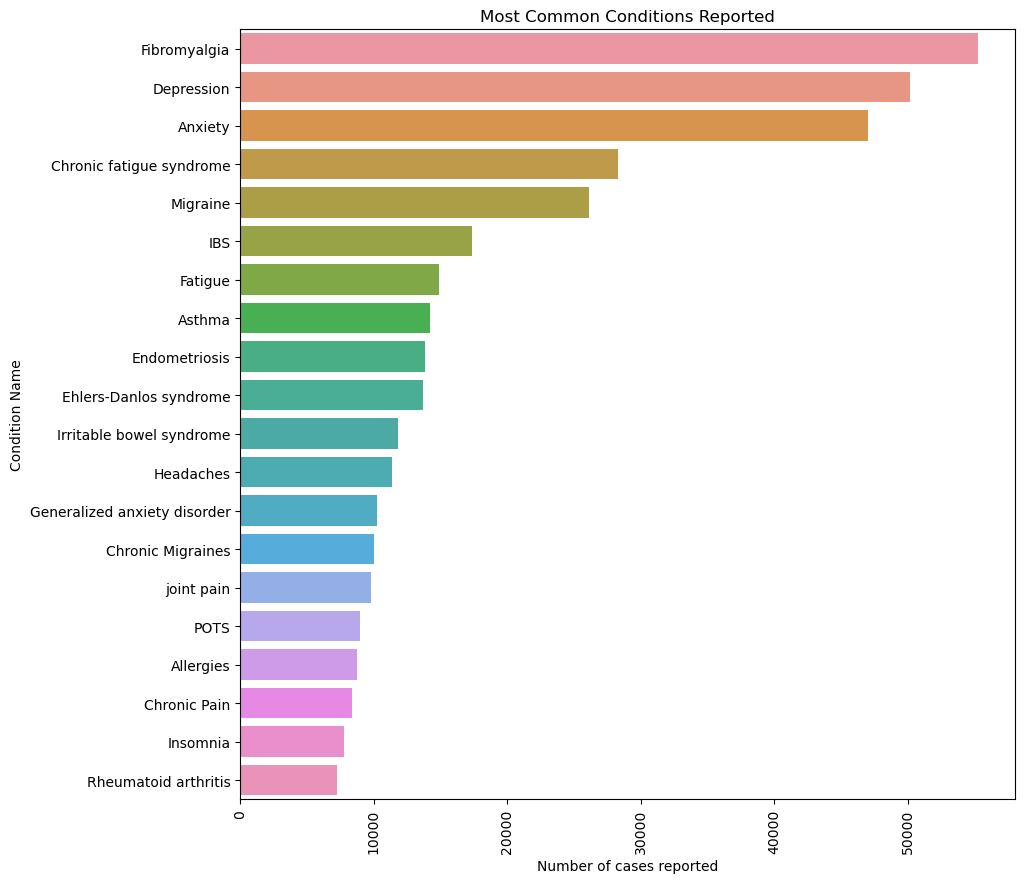

In [41]:
# Viz
plt.figure(figsize=(10,10))
# condition = data[data.trackable_type=="Condition"].trackable_name.value_counts().iloc[0:20]
sns.barplot(x= condition.values, y=condition.index)
# for i, v in enumerate(condition.values):
#     plt.text(0.8,i,v,color='k',fontsize=10)
plt.xticks(rotation='vertical')
plt.xlabel('Number of cases reported')
plt.ylabel('Condition Name')
plt.title("Most Common Conditions Reported")
plt.show()

#### The above doesn't account for the fact that the same person could report the same condition on multiple occasions. Let's see the most common conditions based on the number of unique reports by users for the top 4 conditions 

In [34]:
Users_FMS = pd.DataFrame(data['user_id'][data['trackable_name'] == 'Fibromyalgia'])
FMS = data['user_id'][data['trackable_name'] == 'Fibromyalgia']
print("The number of unique cases of Fibromyalgia reported:", FMS.nunique())


Users_dpn = data['user_id'][data['trackable_name'] == 'Depression']
print("The number of unique cases of Depression reported:", Users_dpn.nunique())


Users_anx = pd.DataFrame(data['user_id'][data['trackable_name']== 'Anxiety'])
anx = data['user_id'][data['trackable_name']== 'Anxiety']
print("The number of unique cases of Anxiety reported:", anx.nunique())


Users_CFS = data['user_id'][data['trackable_name']== 'Chronic fatigue syndrome']
print("The number of unique cases of Chronic Fatigue Syndrome reported:", Users_CFS.nunique())


# Users_RA = data['user_id'][data['trackable_name']== 'Rheumatoid arthritis']
# print("The number of unique cases of Rheumatoid arthritis reported: ", Users_RA.nunique())



print('\n')
print('So we can see that there are actually more unique reports of Anxiety than Fibromyalgia')

The number of unique cases of Fibromyalgia reported: 7872
The number of unique cases of Depression reported: 7846
The number of unique cases of Anxiety reported: 8543
The number of unique cases of Chronic Fatigue Syndrome reported: 3002


So we can see that there are actually more unique reports of Anxiety than Fibromyalgia


#### Let's try to predict the top 20 conditions based on the most common symptoms

In [35]:
# Let's create a dataframe for the symptoms 

symptoms = data[data['trackable_type'] == 'Symptom']
symptoms['trackable_value'] = pd.to_numeric(symptoms['trackable_value']) # in case we want to analyse the trackable value (but we don't know what that is from the description) 

top100symptoms = data[data['trackable_type'] == 'Symptom'].trackable_name.value_counts().iloc[0:100]

# and a dataframe for the conditions 

conditions = data[data['trackable_type'] == 'Condition']
top20conditions = data[data['trackable_type'] == 'Condition'].trackable_name.value_counts().iloc[0:20]
conditions['trackable_value'] = pd.to_numeric(conditions['trackable_value'])


/var/folders/md/rrjv6nbs3136tzvzpg39xpx80000gn/T/ipykernel_7292/3648712138.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symptoms['trackable_value'] = pd.to_numeric(symptoms['trackable_value']) # in case we want to analyse the trackable value (but we don't know what that is from the description)
/var/folders/md/rrjv6nbs3136tzvzpg39xpx80000gn/T/ipykernel_7292/3648712138.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conditions['trackable_value'] = pd.to_numeric(conditions['trackable_value'])


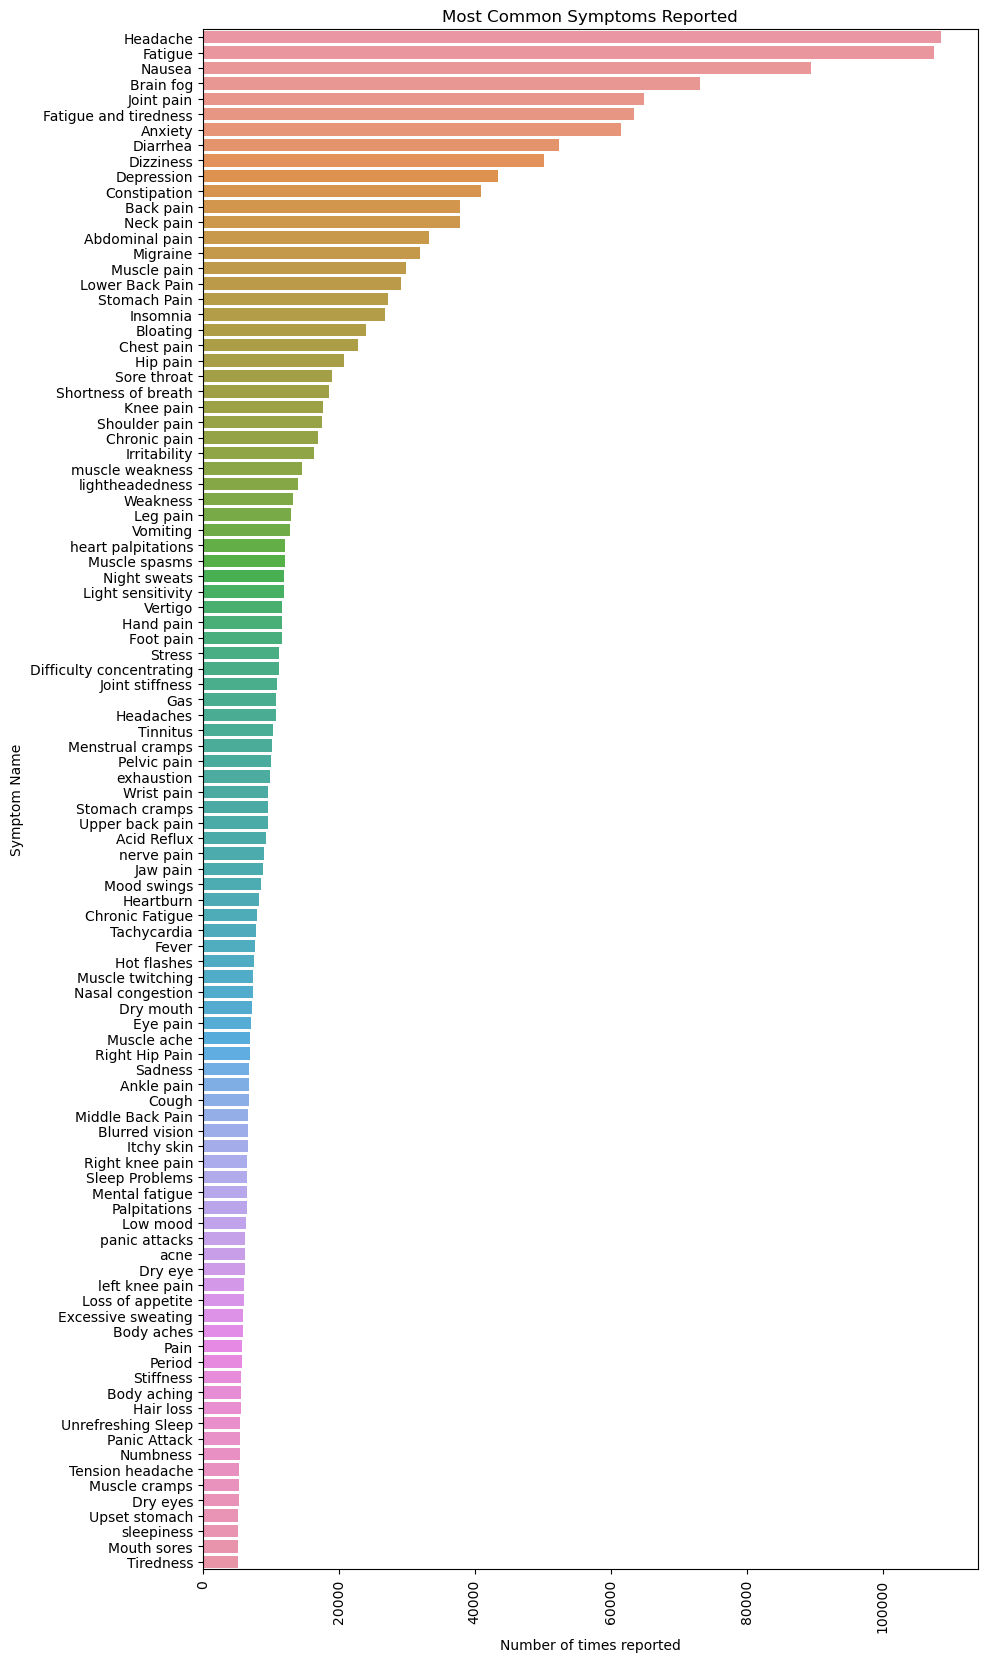

In [43]:
symptoms.head(100)

# Viz 

plt.figure(figsize=(10,20))
# condition = data[data.trackable_type=="Condition"].trackable_name.value_counts().iloc[0:20]
sns.barplot(x= top100symptoms.values, y=top100symptoms.index)
# for i, v in enumerate(condition.values):
#     plt.text(0.8,i,v,color='k',fontsize=10)
plt.xticks(rotation='vertical')
plt.xlabel('Number of times reported')
plt.ylabel('Symptom Name')
plt.title("Most Common Symptoms Reported")
plt.show()


In [44]:
# keep only the top 100 symptoms 

top_100= symptoms[symptoms['trackable_name'].isin(top100symptoms.index)]

top_100.head()

top_100['symptom_present'] = 1  # Would need to have more context of what the trackable_value is, but from my understanding, users can track a specific symptom and then give it a ranking (e.g. severity) on a scale from 1-4, however, they don't HAVE to do this. 

top_100.head()


/var/folders/md/rrjv6nbs3136tzvzpg39xpx80000gn/T/ipykernel_7292/3031125820.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_100['symptom_present'] = 1  # Would need to have more context of what the trackable_value is, but from my understanding, users can track a specific symptom and then give it a ranking (e.g. severity) on a scale from 1-4, however, they don't HAVE to do this.


user_id  age     sex country checkin_date  \
15  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==  2.0  female      CA   2017-04-28   
24  QEVuQwEAO+R1md5HUn8+w1Qpbg7ogw==  NaN     NaN     NaN   2015-05-26   
31  QEVuQwEAO+R1md5HUn8+w1Qpbg7ogw==  NaN     NaN     NaN   2015-05-27   
32  QEVuQwEAO+R1md5HUn8+w1Qpbg7ogw==  NaN     NaN     NaN   2015-05-27   
33  QEVuQwEAO+R1md5HUn8+w1Qpbg7ogw==  NaN     NaN     NaN   2015-05-27   

   trackable_id trackable_type   trackable_name  trackable_value  \
15          123        Symptom  Joint stiffness                3   
24          152        Symptom           Nausea                1   
31          152        Symptom           Nausea                2   
32            8        Symptom          Anxiety                2   
33          242        Symptom          Fatigue                1   

    symptom_present  
15                1  
24                1  
31                1  
32                1  
33                1

In [45]:
# change from long to wide format 

top_100_symptoms_pivot = top_100.pivot_table(columns = 'trackable_name', index=['user_id', 'checkin_date'], values='symptom_present').reset_index()
# joined.pivot_table(columns = 'trackable_name_x', index= 'user_id', values= ['trackable_value', 'value'])


In [46]:
top_100_symptoms_pivot.head()


# change NaNs into 0 (symptom not present/not reported)

top_100_symptoms_pivot = top_100_symptoms_pivot.fillna(0)


top_100_symptoms_pivot.head()

trackable_name                           user_id checkin_date  Abdominal pain  \
0               QEVuQwEA++2fi8XAwh3BnSEwL172Dg==   2019-08-28             0.0   
1               QEVuQwEA++2fi8XAwh3BnSEwL172Dg==   2019-08-29             0.0   
2               QEVuQwEA++2fi8XAwh3BnSEwL172Dg==   2019-09-01             0.0   
3               QEVuQwEA++PmSIrPm0/GE+l1QxEh1g==   2019-03-08             0.0   
4               QEVuQwEA++PmSIrPm0/GE+l1QxEh1g==   2019-03-09             0.0   

trackable_name  Acid Reflux  Ankle pain  Anxiety  Back pain  Bloating  \
0                       0.0         0.0      0.0        0.0       0.0   
1                       0.0         0.0      0.0        0.0       0.0   
2                       0.0         0.0      0.0        0.0       0.0   
3                       0.0         0.0      0.0        0.0       0.0   
4                       0.0         0.0      0.0        0.0       0.0   

trackable_name  Blurred vision  Body aches  ...  Wrist pain  acne  exhaustion  \
0                          0.0         0.0  ...         0.0   0.0         0.0   
1                          0.0         0.0  ...         0.0   0.0         0.0   
2                          0.0         0.0  ...         0.0   0.0         0.0   
3                          0.0         0.0  ...         0.0   0.0         0.0   
4                          0.0         0.0  ...         0.0   0.0         0.0   

trackable_name  heart palpitations  left knee pain  lightheadedness  \
0                              0.0             0.0              0.0   
1                              0.0             0.0              0.0   
2                              0.0             0.0              0.0   
3                              0.0             0.0              0.0   
4                              0.0             0.0              0.0   

trackable_name  muscle weakness  nerve pain  panic attacks  sleepiness  
0                           0.0         0.0            0.0         0.0  
1                           0.0         0.0            0.0         0.0  
2                           0.0         0.0            0.0         0.0  
3                           0.0         0.0            0.0         0.0  
4                           0.0         0.0            0.0         0.0  

[5 rows x 102 columns]

In [47]:
# only keep the top 100 conditions 

top_20_conditions= conditions[conditions['trackable_name'].isin(top20conditions.index)]

top_20_conditions.head()

# top_100['symptom_present'] = 1 

user_id  age  sex country checkin_date  \
30   QEVuQwEAO+R1md5HUn8+w1Qpbg7ogw==  NaN  NaN     NaN   2015-05-27   
42   QEVuQwEAO+R1md5HUn8+w1Qpbg7ogw==  NaN  NaN     NaN   2015-06-10   
50   QEVuQwEAO+R1md5HUn8+w1Qpbg7ogw==  NaN  NaN     NaN   2015-06-11   
59   QEVuQwEAO+R1md5HUn8+w1Qpbg7ogw==  NaN  NaN     NaN   2015-06-14   
135  QEVuQwEA6peEzOOIEaK2Ic9oHMBYjw==  NaN  NaN     NaN   2015-07-06   

    trackable_id trackable_type                trackable_name  trackable_value  
30           423      Condition  Generalized anxiety disorder                3  
42           423      Condition  Generalized anxiety disorder                0  
50           423      Condition  Generalized anxiety disorder                1  
59           423      Condition  Generalized anxiety disorder                0  
135          291      Condition                    Depression                1

In [48]:
# join the conditions to the symptoms df 

df = pd.merge(top_100_symptoms_pivot, top_20_conditions, on=["user_id", "checkin_date"])

In [49]:
df.head(1000)

user_id checkin_date  Abdominal pain  \
0    QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==   2019-09-19             1.0   
1    QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==   2019-09-19             1.0   
2    QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==   2019-09-19             1.0   
3    QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==   2019-09-20             1.0   
4    QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==   2019-09-20             1.0   
..                                ...          ...             ...   
995  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==   2019-01-05             0.0   
996  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==   2019-01-06             0.0   
997  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==   2019-01-06             0.0   
998  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==   2019-01-06             0.0   
999  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==   2019-01-07             0.0   

     Acid Reflux  Ankle pain  Anxiety  Back pain  Bloating  Blurred vision  \
0            0.0         1.0      0.0        0.0       0.0             1.0   
1            0.0         1.0      0.0        0.0       0.0             1.0   
2            0.0         1.0      0.0        0.0       0.0             1.0   
3            0.0         1.0      0.0        0.0       0.0             1.0   
4            0.0         1.0      0.0        0.0       0.0             1.0   
..           ...         ...      ...        ...       ...             ...   
995          0.0         0.0      0.0        0.0       0.0             0.0   
996          0.0         0.0      0.0        0.0       0.0             0.0   
997          0.0         0.0      0.0        0.0       0.0             0.0   
998          0.0         0.0      0.0        0.0       0.0             0.0   
999          0.0         0.0      0.0        0.0       0.0             0.0   

     Body aches  ...  nerve pain  panic attacks  sleepiness   age     sex  \
0           0.0  ...         0.0            0.0         0.0  30.0  female   
1           0.0  ...         0.0            0.0         0.0  30.0  female   
2           0.0  ...         0.0            0.0         0.0  30.0  female   
3           0.0  ...         0.0            0.0         0.0  30.0  female   
4           0.0  ...         0.0            0.0         0.0  30.0  female   
..          ...  ...         ...            ...         ...   ...     ...   
995         0.0  ...         0.0            0.0         0.0  25.0  female   
996         0.0  ...         0.0            0.0         0.0  25.0  female   
997         0.0  ...         0.0            0.0         0.0  25.0  female   
998         0.0  ...         0.0            0.0         0.0  25.0  female   
999         0.0  ...         0.0            0.0         0.0  25.0  female   

     country  trackable_id  trackable_type          trackable_name  \
0         BE           649       Condition                Migraine   
1         BE           886       Condition    Rheumatoid arthritis   
2         BE           397       Condition            Fibromyalgia   
3         BE           649       Condition                Migraine   
4         BE           886       Condition    Rheumatoid arthritis   
..       ...           ...             ...                     ...   
995       GB           350       Condition  Ehlers-Danlos syndrome   
996       GB           358       Condition           Endometriosis   
997       GB           397       Condition            Fibromyalgia   
998       GB           350       Condition  Ehlers-Danlos syndrome   
999       GB           358       Condition           Endometriosis   

     trackable_value  
0                  0  
1                  2  
2                  3  
3                  2  
4                  3  
..               ...  
995                1  
996                2  
997                2  
998                1  
999                0  

[1000 rows x 109 columns]

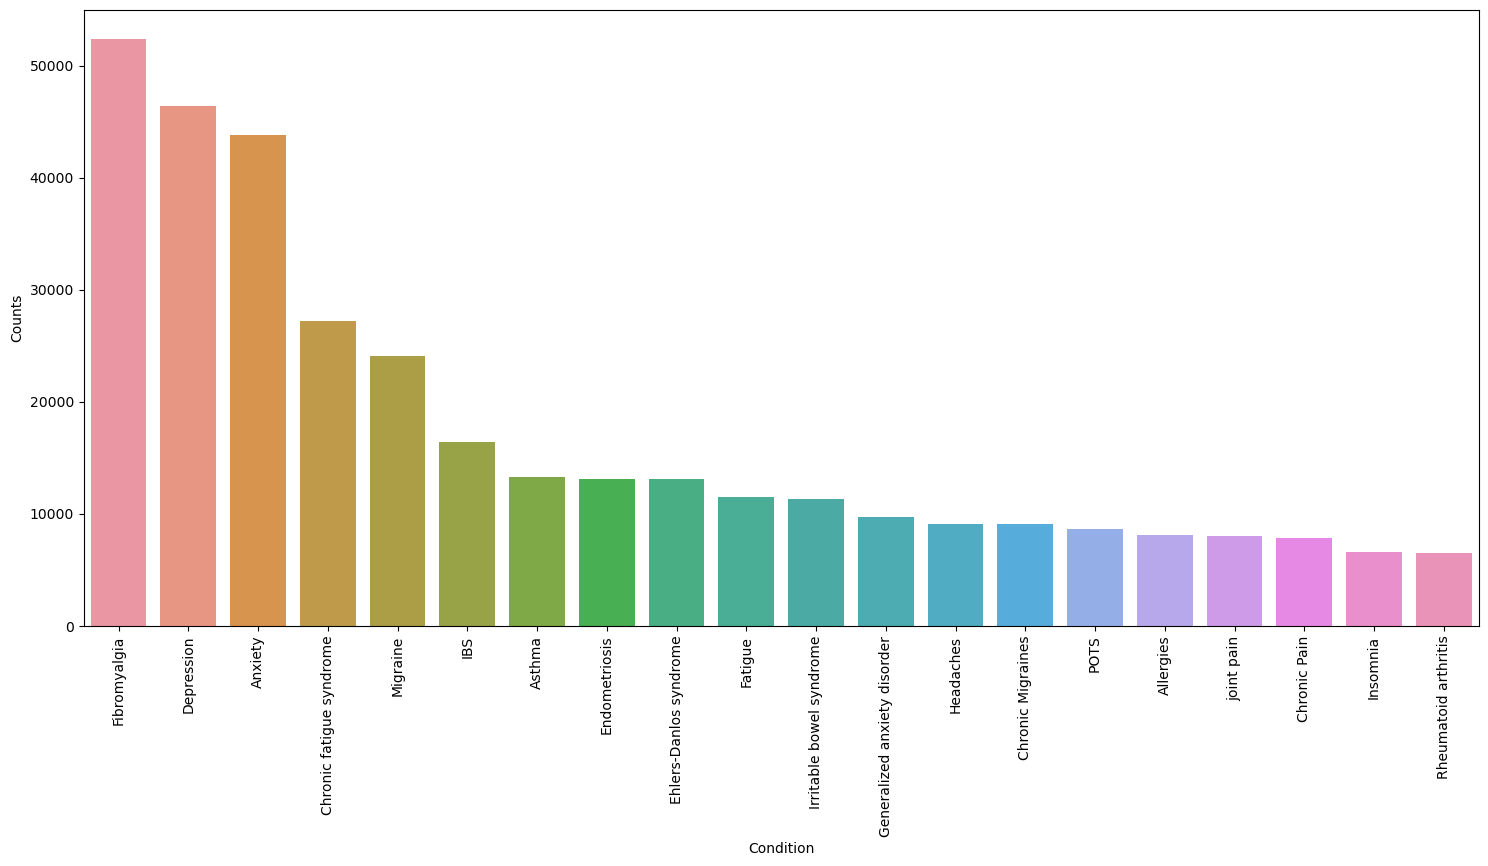

In [50]:
# see if the data is balanced 

# Checking whether the dataset is balanced or not
condition_counts = df["trackable_name"].value_counts()
temp_df = pd.DataFrame({
    "Condition": condition_counts.index,
    "Counts": condition_counts.values
})
 
plt.figure(figsize = (18,8))
sns.barplot(x = "Condition", y = "Counts", data = temp_df)
plt.xticks(rotation=90)
plt.show()



#### We have a very imbalanced dataset. Let's take a smaller number of conditions (let's take just fibromyalgia, anxiety, and depression), and undersample the data from the majority class. 

In [51]:
# features
X = df.drop(['trackable_name', 'user_id', 'checkin_date', 'age', 'sex', 'country', 'trackable_id', 'trackable_type', 'trackable_value'],axis=1)


from sklearn.preprocessing import LabelEncoder

# give each condition a unique value 
encoder = LabelEncoder()
df['trackable_name'] = encoder.fit_transform(df['trackable_name'])


y = df['trackable_name']


df['trackable_name'].nunique() # we have 20 unique conditions as we should have. 

20

In [81]:
encoder

LabelEncoder()

In [52]:
from imblearn.under_sampling import RandomUnderSampler

# Create an instance of RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)

# Apply undersampling to your feature matrix X and target variable y
X_resampled, y_resampled = sampler.fit_resample(X, y)

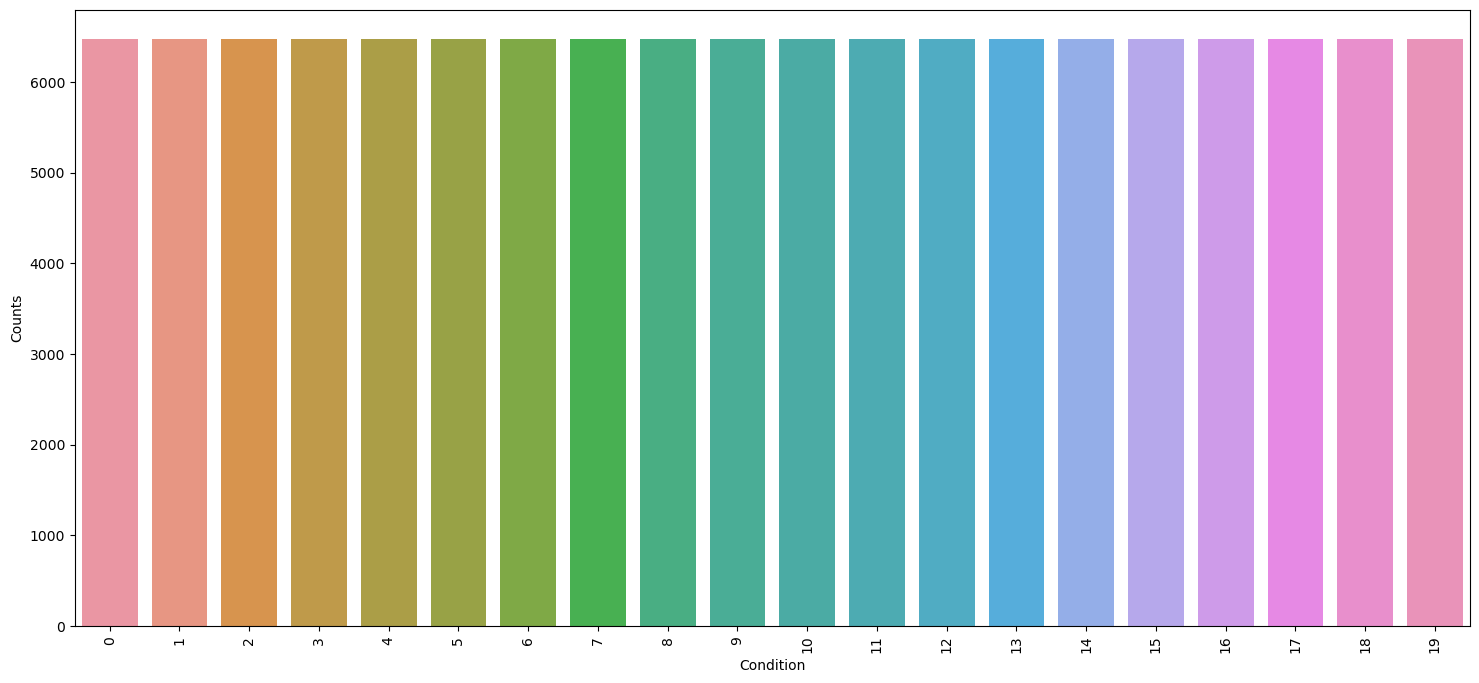

In [53]:
rcondition_counts = y_resampled.value_counts()
temp_df = pd.DataFrame({
    "Condition": rcondition_counts.index,
    "Counts": rcondition_counts.values
})
 
plt.figure(figsize = (18,8))
sns.barplot(x = "Condition", y = "Counts", data = temp_df)
plt.xticks(rotation=90)
plt.show()

#### Let's create a correlation matrix of the symptoms 

<Axes: >

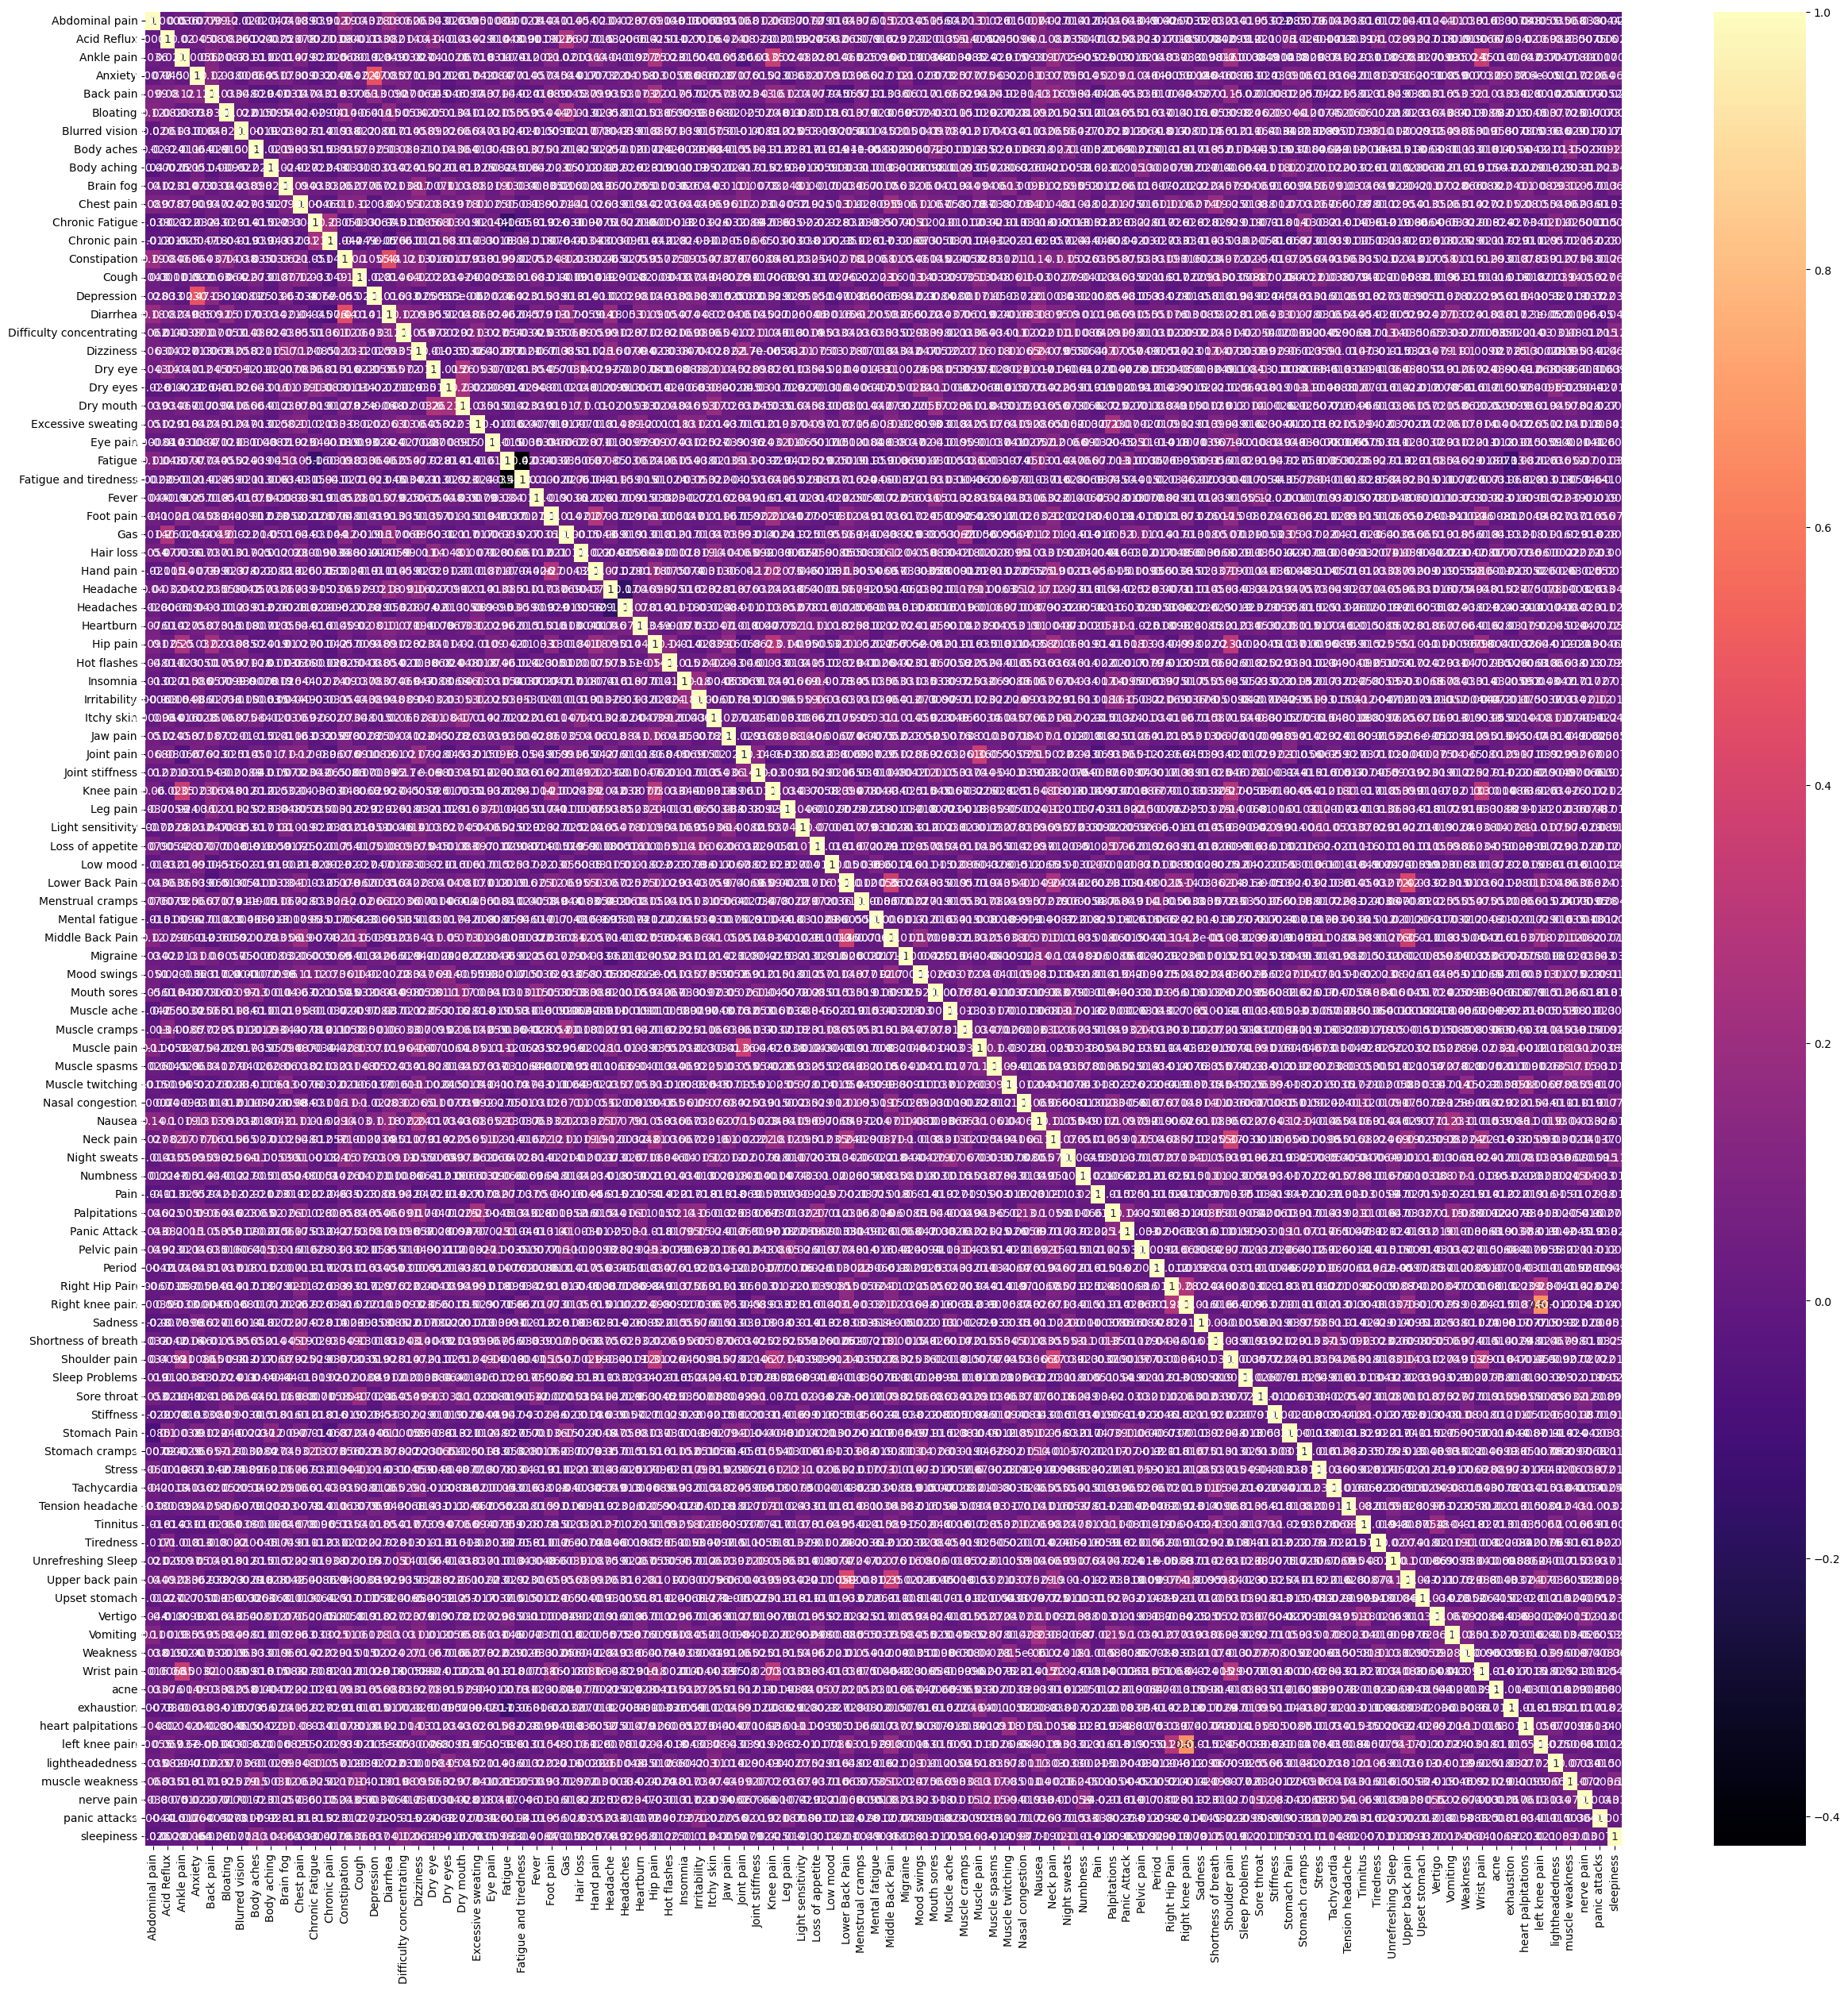

In [54]:
# correlation matrix of symptoms

plt.figure(figsize=(30,30))  
sns.heatmap(X.corr(),cmap='magma',annot=True)


# This clearly isn't that informative a visualisation. Maybe this would be useful to breakdown by condition. 


In [ ]:
# data_sc = df.drop(['user_id', 'checkin_date', 'age', 'sex', 'country', 'trackable_id', 'trackable_type', 'trackable_value'],axis=1)


# corr = data_sc.corr()
# (abs(corr["tr"])).sort_values(ascending=False).head(6)

#### Train test split 

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size=0.30, random_state = 101)


print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (90636, 100), (90636,)
Test: (38844, 100), (38844,)


#### Fit a random forest classifier 

In [65]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [66]:
rfc_pred = rfc.predict(X_test)

In [73]:
# Sort the feature importances 

array([0.01647279, 0.00834898, 0.00638652, 0.02251152, 0.02346295,
       0.01484334, 0.00678134, 0.00632111, 0.0062167 , 0.02144923,
       0.01356093, 0.00799008, 0.01600902, 0.01568381, 0.00625748,
       0.02112158, 0.01725534, 0.00854396, 0.01972757, 0.00437855,
       0.00514821, 0.00558743, 0.00575216, 0.00523124, 0.02741108,
       0.02620677, 0.00663317, 0.00854195, 0.00863718, 0.00371143,
       0.00871793, 0.02483884, 0.00935747, 0.00726265, 0.01437087,
       0.006083  , 0.01746574, 0.0120432 , 0.00653498, 0.00683973,
       0.01762809, 0.00873656, 0.01143272, 0.01034532, 0.0090011 ,
       0.00655833, 0.00638592, 0.0168412 , 0.00934095, 0.00639222,
       0.00425294, 0.01380581, 0.00836321, 0.00335814, 0.00663526,
       0.00420605, 0.01704954, 0.00977712, 0.00538453, 0.00698414,
       0.02473763, 0.01982507, 0.00669488, 0.00582716, 0.007886  ,
       0.00577587, 0.0068059 , 0.00899815, 0.00435136, 0.00616632,
       0.00523519, 0.00777146, 0.00980456, 0.01181898, 0.00674

#### Metrics

In [74]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score

In [75]:
print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred))
report_rfc = classification_report(y_test,rfc_pred, output_dict=True)

rfc_macro_f1 = report_rfc['macro avg']['f1-score']

print("%s: %f " % ('RFC', rfc_macro_f1))

[[1219   15   63   40   36   18   15   23   20   59   17   39   65   14
   107   35   17   27   71   31]
 [  83  374   45   61   81   78  237   66   69   61   47   13   69   83
   132   97  100   75   53  105]
 [ 217   17  787   56  143   27   17   86   56   28   27   54   57   31
    87   91   30   59   74   31]
 [  94   21   22 1116   44   32   19   31   30   60   29   30   54   31
    89   42   25   33   66   59]
 [  15   14   43   35 1295   34   21   34   33   29   32   59   33   27
    82   19   11   44   67   28]
 [  33   39   35   74   97  751   55   55   69   26   67   52   44  122
    66  112   20   84   35  137]
 [  86  231   64   82   73   61  340   61   67   56   76  128   62   72
   112   65  106   50   64   83]
 [  32    6   63  108   62   29   22  857   36   43   33   33   18   30
    75  105   18  208   94   20]
 [  26    9   45   47   31   21   28   93 1096   46   27   57   45   59
    28   65   35   22   84   46]
 [  87   14   24   66   79   33   35   24   33  689   3

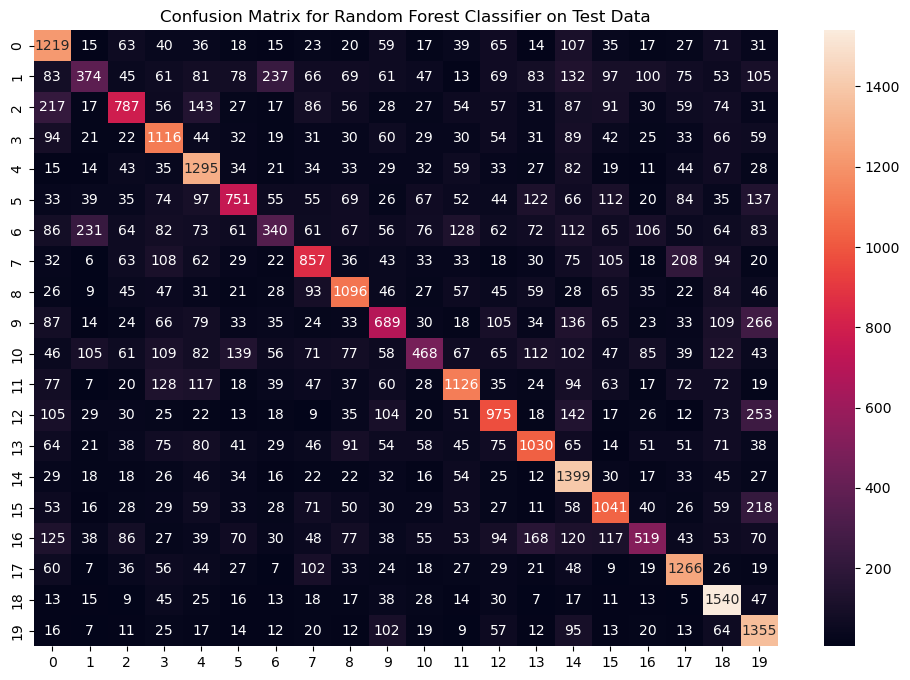

In [85]:
cf_matrix = confusion_matrix(y_test, rfc_pred)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True, fmt='.5g')
plt.title("Confusion Matrix for Random Forest Classifier on Test Data")
plt.show()

#### Improving the model

In [134]:
# Get the feature importances 

importances = rfc.feature_importances_
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]

feature_names = pd.DataFrame(X.columns)

importances = pd.DataFrame(rfc.feature_importances_)

symptoms_importances = pd.concat([feature_names, importances], axis=1)
symptoms_importances.columns= ['symptom name', 'feature importance']

symptoms_importances = symptoms_importances.sort_values('feature importance', ascending=False)

# sorted_importances = importances[sorted_indices]
# sorted_features = X[sorted_indices]
symptoms_importances.head(50)


# # sorted_indices
# X.iloc[:, sorted_indices]


symptom name  feature importance
24                   Fatigue            0.027411
25     Fatigue and tiredness            0.026207
31                  Headache            0.024839
60                    Nausea            0.024738
4                  Back pain            0.023463
3                    Anxiety            0.022512
9                  Brain fog            0.021449
15                Depression            0.021122
61                 Neck pain            0.019825
18                 Dizziness            0.019728
40                Joint pain            0.017628
36                  Insomnia            0.017466
16                  Diarrhea            0.017255
77              Stomach Pain            0.017109
56               Muscle pain            0.017050
47           Lower Back Pain            0.016841
0             Abdominal pain            0.016473
12              Chronic pain            0.016009
13              Constipation            0.015684
5                   Bloating            0.014843
34                  Hip pain            0.014371
51                  Migraine            0.013806
10                Chest pain            0.013561
37              Irritability            0.012043
73             Shoulder pain            0.011819
42                 Knee pain            0.011433
95           lightheadedness            0.011229
88                  Vomiting            0.010366
43                  Leg pain            0.010345
75               Sore throat            0.009953
72       Shortness of breath            0.009805
57             Muscle spasms            0.009777
97                nerve pain            0.009551
32                 Headaches            0.009357
48          Menstrual cramps            0.009341
89                  Weakness            0.009328
87                   Vertigo            0.009326
93        heart palpitations            0.009316
96           muscle weakness            0.009277
44         Light sensitivity            0.009001
67               Pelvic pain            0.008998
78            Stomach cramps            0.008789
41           Joint stiffness            0.008737
30                 Hand pain            0.008718
28                       Gas            0.008637
17  Difficulty concentrating            0.008544
27                 Foot pain            0.008542
92                exhaustion            0.008446
52               Mood swings            0.008363
1                Acid Reflux            0.008349

#### Let's plot out these feature importances 

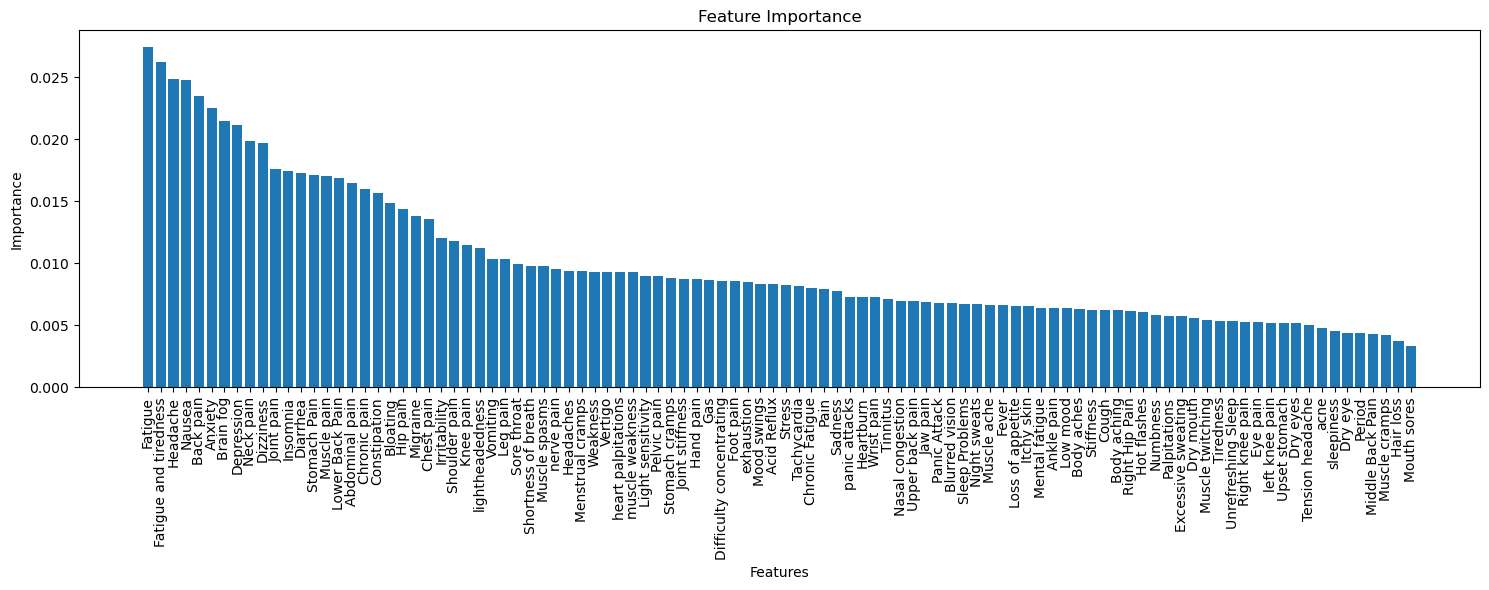

In [136]:

plt.figure(figsize=(15,6))
plt.bar(data=symptoms_importances, x='symptom name', height= 'feature importance')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [141]:
print('We could attempt to reduce the dimensionality of the model by only including the most important features. \n In future, it may be better to work with the most commonly reported condition (Fibromyalgia) to predict whether an \n individual has the condition or not based on their symptoms. Working with too many conditions (20) perhaps is not \n the best way forward.')





We could attempt to reduce the dimensionality of the model by only including the most important features. 
 In future, it may be better to work with the most commonly reported condition (Fibromyalgia) to predict whether an 
 individual has the condition or not based on their symptoms. Working with too many conditions (20) perhaps is not 
 the best way forward.


#### Hyperparameter tuning with GridSearch 

In [77]:
# # Dictionary of parameters 

param_grid = { 
    'n_estimators': [10,100,500,1000],
    'max_depth' : [2,4,6,10,20],
    'criterion' :['gini', 'entropy']
}

In [78]:
from sklearn.model_selection import GridSearchCV

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 10, 20],
                         'n_estimators': [10, 100, 500, 1000]})

In [79]:
CV_rfc.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 500}

In [80]:
grid_predictions = CV_rfc.predict(X_test)

print('*** Original Random Forest Results ***')
print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred))
print('\n')
print('*** New Random Forest Results - after hyperparameter optimisation ***')
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))


report_rfc_new = classification_report(y_test,grid_predictions, output_dict=True)
rfc_macro_f1_new = report_rfc_new['macro avg']['f1-score']
print("%s: %f " % ('RFC', rfc_macro_f1))
print("%s: %f " % ('RFC new', rfc_macro_f1_new))


*** Original Random Forest Results ***
[[1219   15   63   40   36   18   15   23   20   59   17   39   65   14
   107   35   17   27   71   31]
 [  83  374   45   61   81   78  237   66   69   61   47   13   69   83
   132   97  100   75   53  105]
 [ 217   17  787   56  143   27   17   86   56   28   27   54   57   31
    87   91   30   59   74   31]
 [  94   21   22 1116   44   32   19   31   30   60   29   30   54   31
    89   42   25   33   66   59]
 [  15   14   43   35 1295   34   21   34   33   29   32   59   33   27
    82   19   11   44   67   28]
 [  33   39   35   74   97  751   55   55   69   26   67   52   44  122
    66  112   20   84   35  137]
 [  86  231   64   82   73   61  340   61   67   56   76  128   62   72
   112   65  106   50   64   83]
 [  32    6   63  108   62   29   22  857   36   43   33   33   18   30
    75  105   18  208   94   20]
 [  26    9   45   47   31   21   28   93 1096   46   27   57   45   59
    28   65   35   22   84   46]
 [  87   14   24

In [ ]:
# Confusion matrix of new model 

In [ ]:
cf_matrix = confusion_matrix(y_test,grid_predictions)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True, fmt='.5g')
plt.title("Confusion Matrix for New Random Forest Classifier on Test Data")
plt.show()

#### Predicting condition (from the 20 in our model) based on a dictionary of symptoms (of the 100 included in our model) 

In [148]:
# symptoms = X.columns.values
 
# # Creating a symptom index dictionary to encode the
# # input symptoms into numerical form
# symptom_index = {}
# for index, value in enumerate(symptoms):
#     symptom = " ".join([i.capitalize() for i in value.split("_")])
#     symptom_index[symptom] = index
 
# data_dict = {
#     "symptom_index":symptom_index,
#     "predictions_classes":encoder.classes_
# }
 
# # Defining the Function
# # Input: string containing symptoms separated by commas
# # Output: Generated predictions by models
# def predictDisease(symptoms):
#     symptoms = symptoms.split(",")
     
#     # creating input data for the models
#     input_data = [0] * len(data_dict["symptom_index"])
#     for symptom in symptoms:
#         index = data_dict["symptom_index"][symptom]
#         input_data[index] = 1
         
#     # reshaping the input data and converting it
#     # into suitable format for model predictions
#     input_data = np.array(input_data).reshape(1,-1)
     
#     # generating individual outputs
#     rf_prediction = data_dict["predictions_classes"][rfc.predict(input_data)[0]]
     
# #     # making final prediction by taking mode of all predictions
# #     final_prediction = mode([rf_prediction, nb_prediction, svm_prediction])[0][0]
#     predictions = {
#         "rf_model_prediction": rf_prediction,
# #         "naive_bayes_prediction": nb_prediction,
# #         "svm_model_prediction": svm_prediction,
# #         "final_prediction":final_prediction
#     }
#     return predictions
# # Testing the function
# print(predictDisease("Fatigue,Headache,Nausea"))

{'rf_model_prediction': 'Chronic fatigue syndrome'}


/Users/elisekanber/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [145]:
# data_dict

{'symptom_index': {'Abdominal pain': 0,
  'Acid reflux': 1,
  'Ankle pain': 2,
  'Anxiety': 3,
  'Back pain': 4,
  'Bloating': 5,
  'Blurred vision': 6,
  'Body aches': 7,
  'Body aching': 8,
  'Brain fog': 9,
  'Chest pain': 10,
  'Chronic fatigue': 11,
  'Chronic pain': 12,
  'Constipation': 13,
  'Cough': 14,
  'Depression': 15,
  'Diarrhea': 16,
  'Difficulty concentrating': 17,
  'Dizziness': 18,
  'Dry eye': 19,
  'Dry eyes': 20,
  'Dry mouth': 21,
  'Excessive sweating': 22,
  'Eye pain': 23,
  'Fatigue': 24,
  'Fatigue and tiredness': 25,
  'Fever': 26,
  'Foot pain': 27,
  'Gas': 28,
  'Hair loss': 29,
  'Hand pain': 30,
  'Headache': 31,
  'Headaches': 32,
  'Heartburn': 33,
  'Hip pain': 34,
  'Hot flashes': 35,
  'Insomnia': 36,
  'Irritability': 37,
  'Itchy skin': 38,
  'Jaw pain': 39,
  'Joint pain': 40,
  'Joint stiffness': 41,
  'Knee pain': 42,
  'Leg pain': 43,
  'Light sensitivity': 44,
  'Loss of appetite': 45,
  'Low mood': 46,
  'Lower back pain': 47,
  'Menstrua

#### Closing remarks (for now)

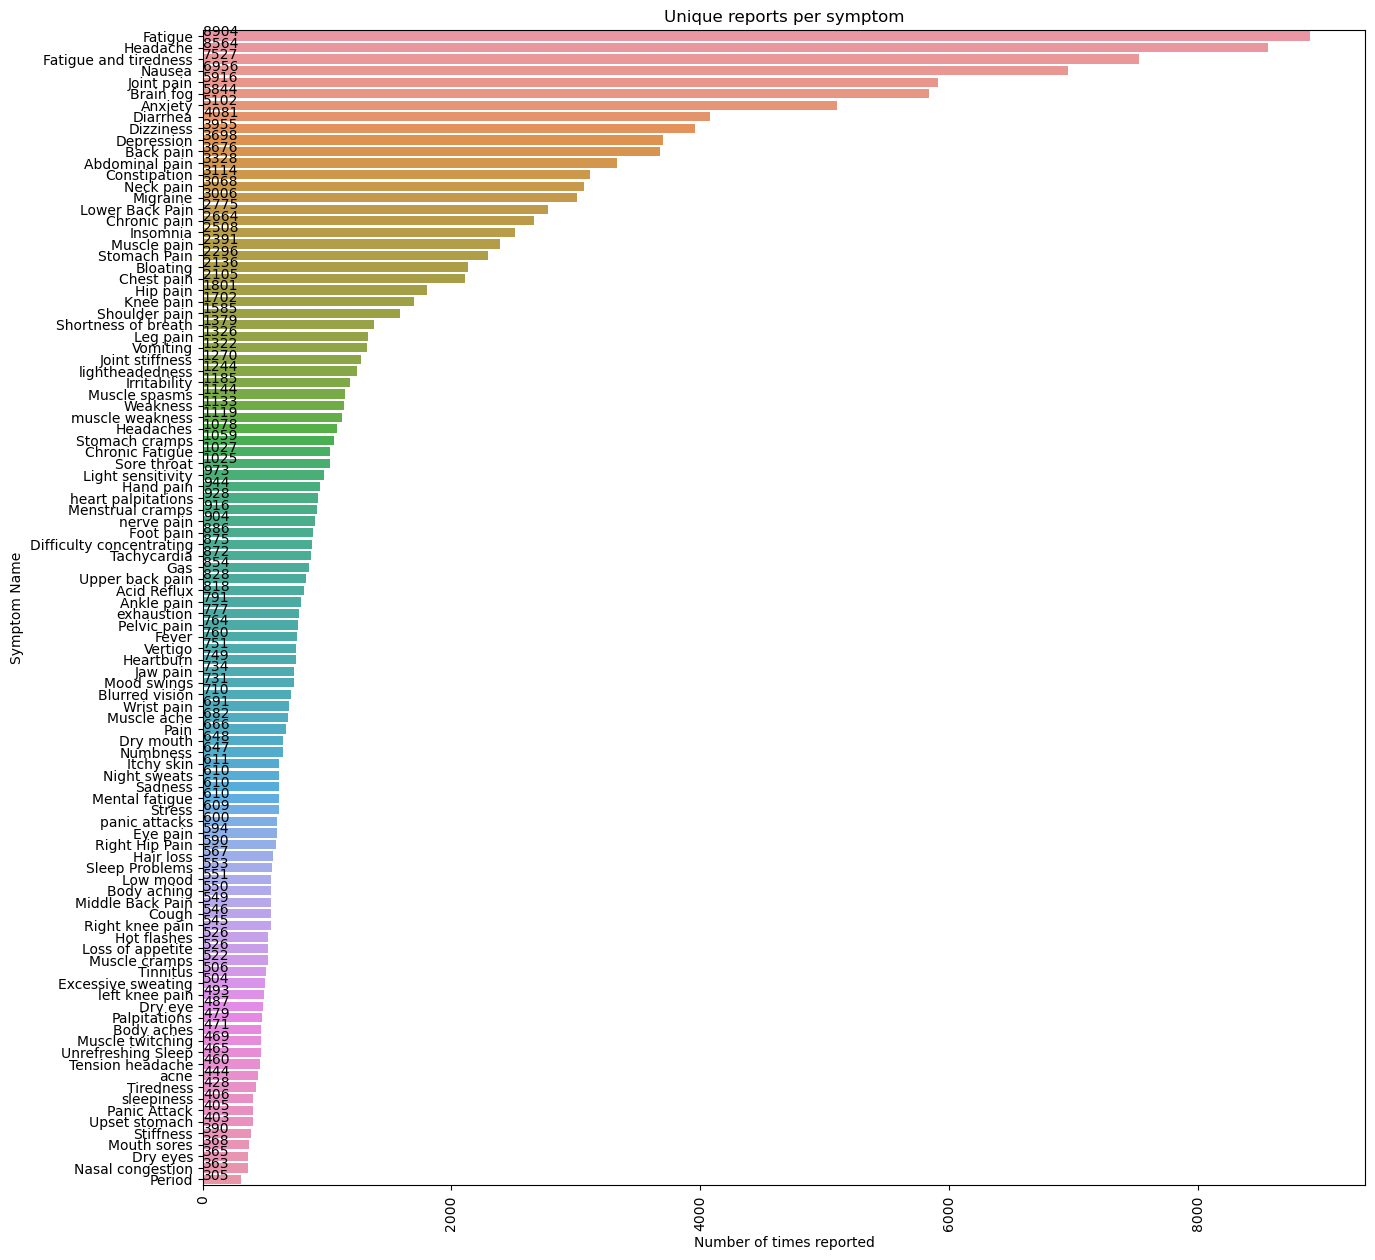

In [144]:
def count_unique_users_per_condition(dataframe, condition_column, user_column):
    unique_users_per_condition = dataframe.groupby(condition_column)[user_column].nunique()
    return unique_users_per_condition


# Unique reports of particular symptoms
unique_users = count_unique_users_per_condition(top_100, 'trackable_name', 'user_id')

# arrange in descending order

unique_users = unique_users.sort_values(ascending=False)




plt.figure(figsize=(15,15))
sns.barplot(x= unique_users.values, y=unique_users.index)
for i, v in enumerate(unique_users.values):
    plt.text(0.8,i,v,color='k',fontsize=10)
plt.xticks(rotation='vertical')
plt.xlabel('Number of times reported')
plt.ylabel('Symptom Name')
plt.title("Unique reports per symptom")
plt.show()

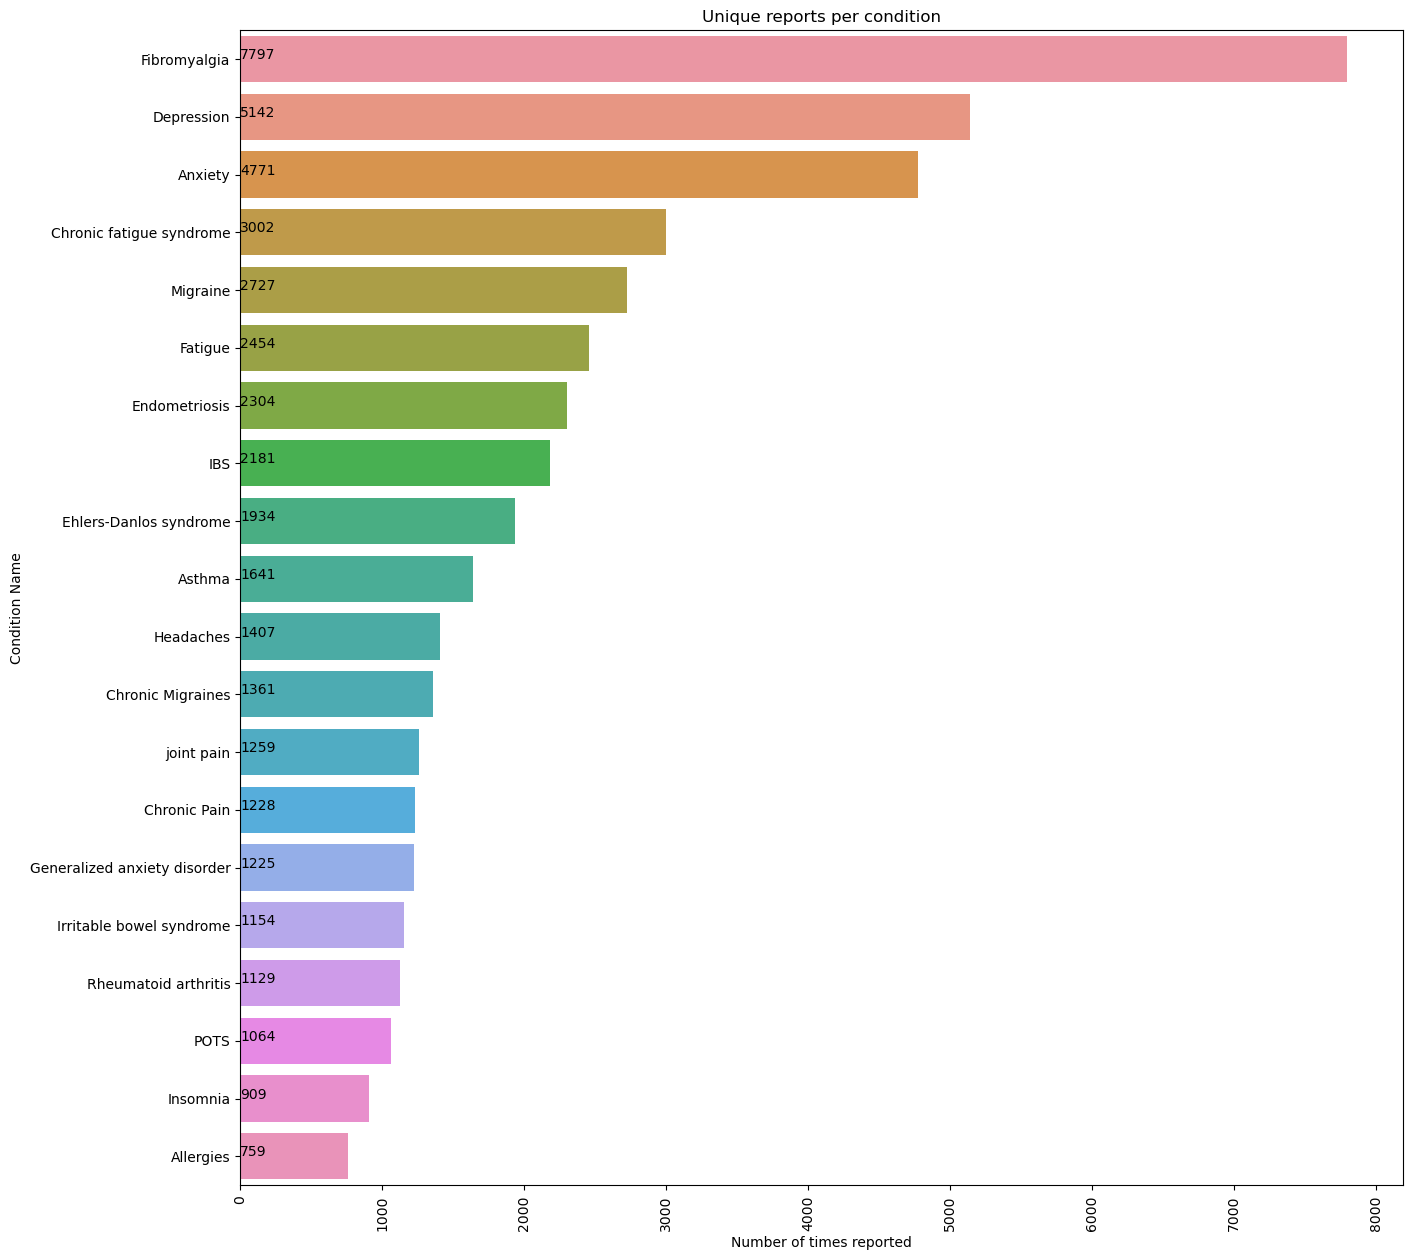

In [146]:
# unique reports of particular conditions

unique_cond_reports = count_unique_users_per_condition(top_20_conditions, 'trackable_name', 'user_id')

# sort descending 

unique_cond_reports = unique_cond_reports.sort_values(ascending=False)



plt.figure(figsize=(15,15))
sns.barplot(x= unique_cond_reports.values, y=unique_cond_reports.index)
for i, v in enumerate(unique_cond_reports.values):
    plt.text(0.8,i,v,color='k',fontsize=10)
plt.xticks(rotation='vertical')
plt.xlabel('Number of times reported')
plt.ylabel('Condition Name')
plt.title("Unique reports per condition")
plt.show()

#### We can see that the number of unique reports of the top 20 conditions is highest for Fibromyalgia, Depression, and Anxiety, and there are not many unique reports of conditions such as "Allergies" or "Insomnia". Therefore, perhaps a better approach in future would be to focus on the most highly reported condition or conditions, rather than trying to classify too many conditions and ending up with a model that does not have good predictive power. 


#### What I would do differently in future: 
#### 1) Narrow down the focus - instead of trying to predict too many conditions and using the most reported symptoms across ALL conditions, trying instead to narrow the research question to trying to predict one or a few conditions. 

#### 2) Use more than one classifier to see how others handle this dataset - combine the predictions of the models to make our overall prediction more robust and accurate. 

#### 3) Spend more time exploring and understanding the data 






